# Investigate future prediction capacity of trained models
Evaluate the ability of trained models optimized for next timestep (i.e. 1 step ahead) prediction to generalize to predicting longer horizons (i.e. an arbitrary number of future timesteps).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils import DEVICE
from copy import deepcopy
from datetime import datetime
from omegaconf import OmegaConf
from train._main import train_model
from data._main import get_dataset
from data._utils import load_Kato2015, load_Uzel2022
from predict._utils import model_predict
from models._utils import LinearNN, NetworkLSTM, NeuralTransformer, NeuralCFC
from visualization._utils import plot_targets_predictions, plot_correlation_scatterplot

In [59]:
# load your trained model checkpoint of choice
PATH = "../logs/hydra/2023_05_03_15_30_23/0/checkpoints/20_epochs_240_worms.pt"
checkpoint = torch.load(PATH, map_location=torch.device(DEVICE))
for key in checkpoint.keys():
    print(key)

model_state_dict
optimizer_state_dict
dataset_name
model_name
optimizer_name
epoch
seq_len
tau
loss
learning_rate
smooth_data
input_size
hidden_size
num_layers
loss_name
reg_param
timestamp
elapsed_time_seconds
covered_neurons
worm_timesteps
num_worm_cohorts
num_unique_worms


In [60]:
# get checkpoint variables

# state dictionaries
model_state_dict = checkpoint["model_state_dict"]
optimizer_state_dict = checkpoint["optimizer_state_dict"]

# training params
epoch = checkpoint["epoch"]
seq_len = checkpoint["seq_len"]
tau = checkpoint["tau"]
smooth_data = checkpoint["smooth_data"]

# model instance params
input_size = checkpoint["input_size"]
hidden_size = checkpoint["hidden_size"]
num_layers = checkpoint["num_layers"]
loss_name = checkpoint["loss_name"]
reg_param = checkpoint["reg_param"]

# names
model_name = checkpoint["model_name"]
train_dataset_name = checkpoint["dataset_name"]

# print info
print(
    "{} model was trained on dataset {} containing sequences of length "
    "{} for {} epochs to predict {} timesteps into the future.".format(
        model_name,
        train_dataset_name,
        seq_len,
        epoch,
        tau,
    )
)

NeuralTransformer model was trained on dataset Kato2015 containing sequences of length 100 for 20 epochs to predict 1 timesteps into the future.


In [61]:
# load model checkpoint
model = eval(model_name)(input_size, hidden_size, num_layers)
model.load_state_dict(model_state_dict)
model.eval()
print(model)

# load optimizer checkpoint
optimizer = torch.optim.SGD(model.parameters(), lr=0.0)  # turn off learning
optimizer.load_state_dict(optimizer_state_dict)
print(optimizer)

NeuralTransformer(
  (identity): Identity()
  (linear): Linear(in_features=1024, out_features=302, bias=True)
  (position_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (expansion_recoder): Linear(in_features=302, out_features=1024, bias=True)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0): Head(
            (key): Linear(in_features=1024, out_features=256, bias=False)
            (query): Linear(in_features=1024, out_features=256, bias=False)
            (value): Linear(in_features=1024, out_features=256, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): Head(
            (key): Linear(in_features=1024, out_features=256, bias=False)
            (query): Linear(in_features=1024, out_features=256, bias=False)
            (value): Linear(in_features=1024, out_features=256, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
        

In [62]:
# ideally, evaluate the model on a test dataset that it was not trained on
test_dataset = load_Kato2015()  # dataset of multiple worms
# test_dataset = load_Uzel2022()  # dataset of multiple worms
print("Dataset keys:", list(test_dataset["worm0"].keys()), end="\n\n")

# determine if the test dataset was seen during training
test_dataset_name = test_dataset["worm0"]["dataset"]
in_distribution = test_dataset_name in train_dataset_name
dataset_inclusion_str = int(not in_distribution) * "un" + "familiar"
print(
    "The (train) dataset(s) the model was trained on:", train_dataset_name, end="\n\n"
)
print("The (test) dataset to make predictions on:", test_dataset_name, end="\n\n")
print("Was the test dataset seen during training?", "YES" if in_distribution else "NO")

Dataset keys: ['dataset', 'smooth_method', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'max_timesteps', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot']

The (train) dataset(s) the model was trained on: Kato2015

The (test) dataset to make predictions on: Kato2015

Was the test dataset seen during training? YES


In [63]:
# get values from the test dataset to use for prediciton and plots
named_neurons_mask = test_dataset["worm0"]["named_neurons_mask"]
if smooth_data:
    calcium_data = test_dataset["worm0"]["smooth_calcium_data"]
else:
    calcium_data = test_dataset["worm0"]["calcium_data"]
time_in_seconds = test_dataset["worm0"]["time_in_seconds"]
max_timesteps = test_dataset["worm0"]["max_timesteps"]
slot_to_named_neuron = test_dataset["worm0"]["slot_to_named_neuron"]

In [64]:
# pick one of the labeled neurons in the test dataset to inspect
named_neuron_inds = torch.where(named_neurons_mask)[0].numpy()
# nidx = np.random.choice(named_neuron_inds)  # pick a neuron to plot
nidx = 53  # index for neuron AVAL
neuron_name = slot_to_named_neuron[nidx]

print("picked neuron index:", nidx)
print("picked neuron name:", neuron_name)

picked neuron index: 53
picked neuron name: AVAL


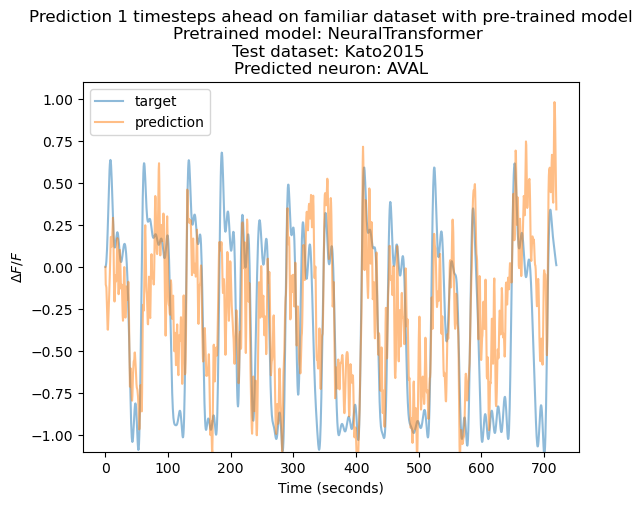

In [65]:
# make predictions of the future timesteps
time_slice = range(0, max_timesteps)
tau_out = 1
inputs, predictions, targets = model_predict(
    model, calcium_data[time_slice, :] * named_neurons_mask, tau=tau_out
)

# plot what the predictions versus targets looks like
plt.plot(
    time_in_seconds[time_slice],
    targets[:, nidx],
    label="target",
    alpha=0.5,
)

plt.plot(
    time_in_seconds[time_slice],
    predictions[:, nidx],
    label="prediction",
    alpha=0.5,
)

plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("$\Delta F / F$")
plt.ylim([-1.1, 1.1])
plt.title(
    "Prediction %s timesteps ahead on %s dataset with pre-trained model\nPretrained model: %s \nTest dataset: %s \nPredicted neuron: %s"
    % (tau_out, dataset_inclusion_str, model_name, test_dataset_name, neuron_name)
)
plt.show()

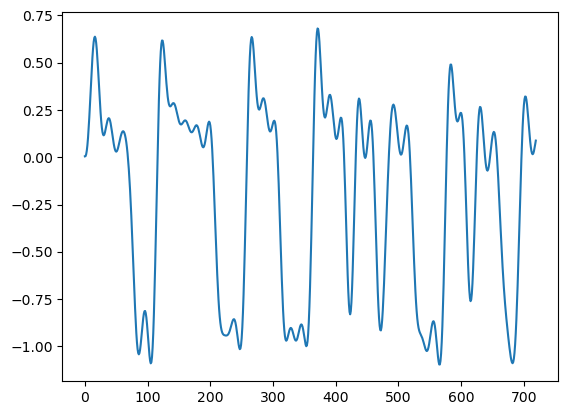

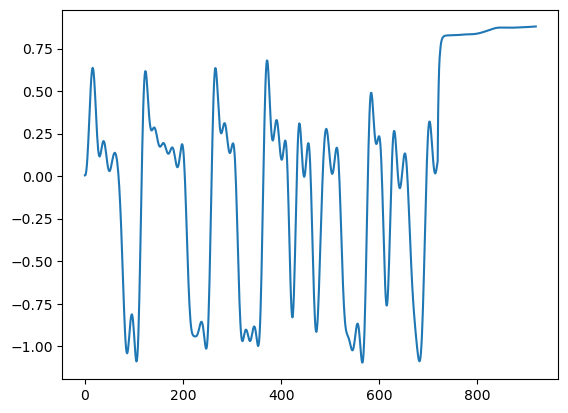

In [66]:
# investigate model ability to complete a sequence

time_slice = range(0, max_timesteps // 2)
input = calcium_data[time_slice, :] * named_neurons_mask
timesteps = 200

output = model.generate(input, timesteps)

plt.plot(input[:, nidx])
plt.show()
plt.plot(output.detach().cpu().squeeze(0)[:, nidx])
plt.show()

In [29]:
# # what if we continue training a pretrained model but with a different tau?

# # get the same dataset the model was trained on
# dataset_config = OmegaConf.load("../conf/dataset.yaml")
# dataset_config.dataset.name = train_dataset_name.split("_")
# dataset = get_dataset(dataset_config)
# print(OmegaConf.to_yaml(dataset_config))

# # load the pretrained model
# pretrained_model = deepcopy(model)

# # train the model (same dataset but different tau param)
# train_config = OmegaConf.load("../conf/train.yaml")
# train_config.train.tau_in = 20  # modify the tau_in parameter
# train_config.train.epochs = 1
# train_config.train.k_splits = 2
# train_config.train.seq_len = 100
# train_config.train.optimizer = "SGD"
# print(OmegaConf.to_yaml(train_config))

# now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
# pretrained_model.train()
# train_model(
#     pretrained_model,
#     dataset,
#     train_config,
#     shuffle=False,
#     log_dir="../logs/test/%s" % now,
# )

Chosen dataset(s): ['Uzel2022']
Num. worms: 6

dataset:
  name:
  - Uzel2022

